# xgboost

## Fit a model and make global and local explanations


Predict whether a student will dropout from their class.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split

import xgboost as xgb
from xgboost import plot_importance

import eli5

from feature_engine.selection import SmartCorrelatedSelection

## Load data

To obtain the data, check the folder `prepare-data` in this repo, or section 2 in the course.

In [2]:
df = pd.read_csv('../../student_dropout_trees.csv')

print(df.shape)

df.head()

(4424, 102)


,Application order,Daytime/evening attendance\t,Previous qualification (grade),Admission grade,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,...,Nacionality_Italian,Nacionality_Cape Verdean,Nacionality_Turkish,Nacionality_Moldova (Republic of),Nacionality_Guinean,Nacionality_Colombian,Nacionality_German,Nacionality_Cuban,Nacionality_Russian,Nacionality_English
0,5,1,122.0,127.3,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,160.0,142.5,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,5,1,122.0,124.8,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,2,1,122.0,119.6,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,100.0,141.5,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# Split the data

X_train, X_test, y_train, y_test = train_test_split(
    df.drop("dropout", axis=1),
    df["dropout"],
    test_size=0.2,
    random_state=1,
)

X_train.shape, X_test.shape

((3539, 101), (885, 101))

In [4]:
# Fraction of students who drops out.

y_train.mean(), y_test.mean()

(0.3241028539135349, 0.3096045197740113)

## xgboost

Train an XGBoost classifier.

In [5]:
# fit model

model = xgb.XGBClassifier(n_estimators=10, random_state=42)

model.fit(X_train, y_train)

print(f"Accuracy in train set: {model.score(X_train, y_train)}")
print(f"Accuracy in test set: {model.score(X_test, y_test)}")

Accuracy in train set: 0.9112743712913253
Accuracy in test set: 0.8745762711864407


The model is a good fit of the data.

## Feature importance - global

C:\Users\Sole\Documents\Repositories\envs\fsml\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


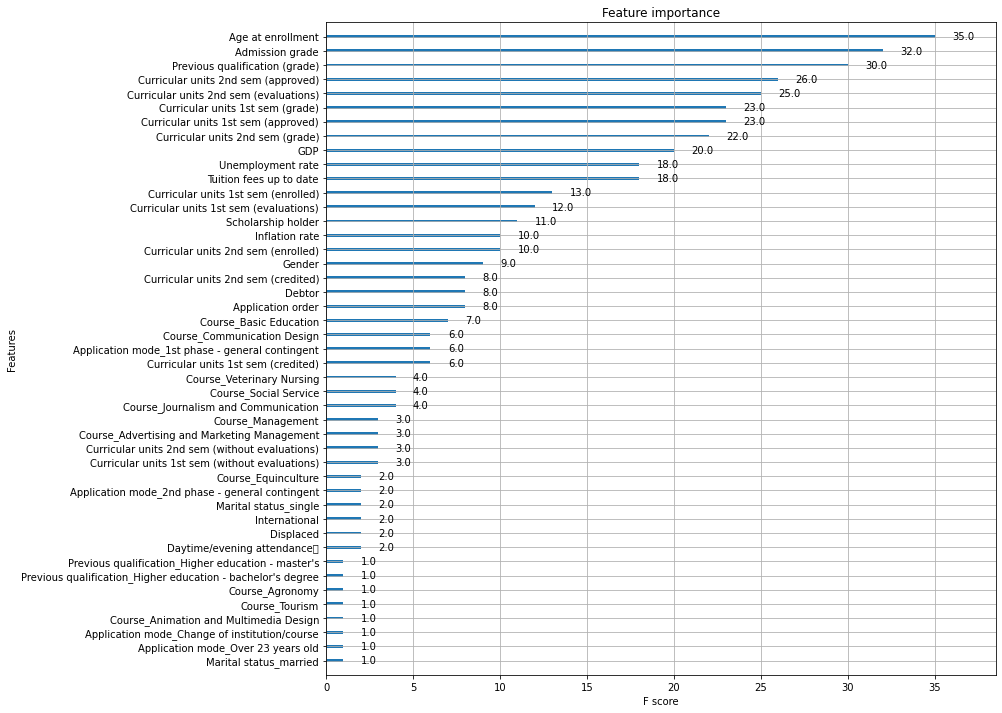

In [6]:
# Plot the feature importances with xgb library

fig, ax = plt.subplots(figsize=(12, 12))
plot_importance(model, ax=ax)
plt.show()

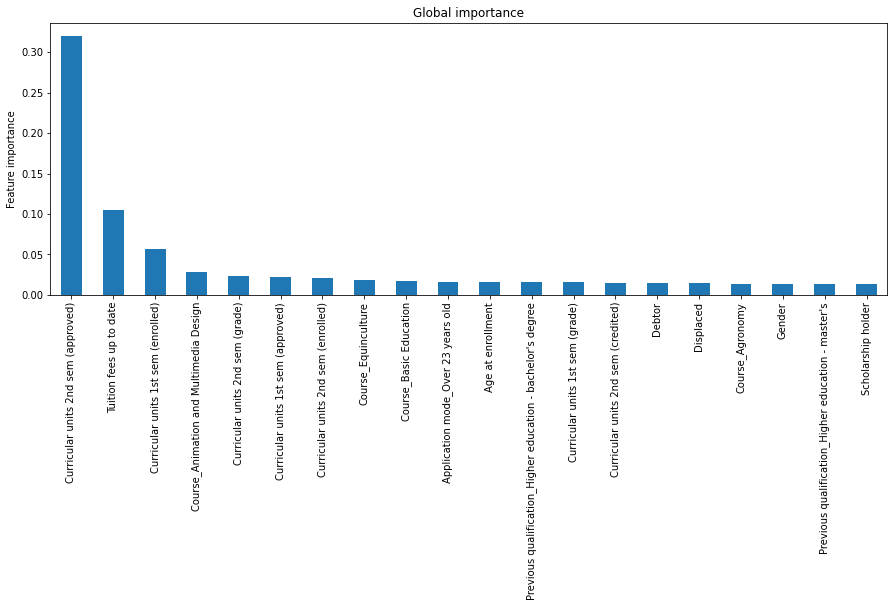

In [7]:
# Plot the feature importances with sklearn

s = pd.Series(
    model.feature_importances_,
    index=model.feature_names_in_,
)

s.sort_values(ascending=False).head(20).plot.bar(figsize=(15,5))
plt.ylabel("Feature importance")
plt.title("Global importance")
plt.show()

## Remove correlated variables

Identify groups of variables that are correlated and retain the one with the greatest variability.

In [8]:
# I use this transformer from Feature-engine, but you may have as
# well done this manually.

sel = SmartCorrelatedSelection(threshold=0.8, selection_method='variance').fit(
    X_train, y_train)

# Retain variable with highest variability from
# each group

X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

X_train.shape, X_test.shape

((3539, 93), (885, 93))

## xgboost - take 2

In [9]:
# fit model

model = xgb.XGBClassifier(n_estimators=10, random_state=42)

model.fit(X_train, y_train)

print(f"Accuracy in train set: {model.score(X_train, y_train)}")
print(f"Accuracy in test set: {model.score(X_test, y_test)}")

Accuracy in train set: 0.9092964114156541
Accuracy in test set: 0.8711864406779661


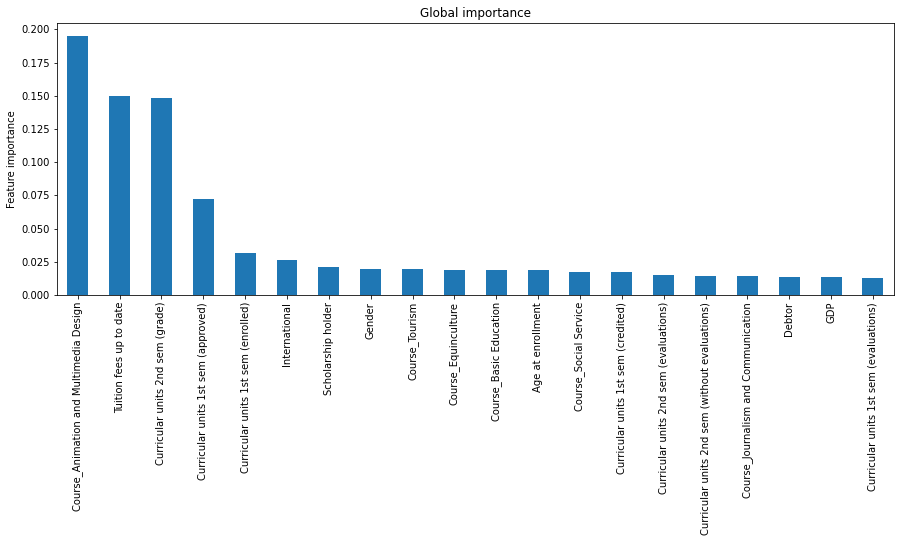

In [10]:
# Plot the feature importances with sklearn

s = pd.Series(
    model.feature_importances_,
    index=model.feature_names_in_,
)

s.sort_values(ascending=False).head(20).plot.bar(figsize=(15,5))
plt.ylabel("Feature importance")
plt.title("Global importance")
plt.show()

Note the change in importance in some features after removing their correlated counterparts.

## Local explanations

Evaluate observations 525 and 3017 from the test set and draw some conclusions.

In [11]:
X_test.head()

,Application order,Daytime/evening attendance\t,Previous qualification (grade),Admission grade,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,...,Nacionality_Italian,Nacionality_Cape Verdean,Nacionality_Turkish,Nacionality_Moldova (Republic of),Nacionality_Guinean,Nacionality_Colombian,Nacionality_German,Nacionality_Cuban,Nacionality_Russian,Nacionality_English
44,1,0,133.1,109.7,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3411,4,1,129.0,120.0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4212,2,1,125.0,115.6,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3037,1,1,126.0,126.7,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1672,1,1,130.0,130.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
eli5.show_prediction(
    model, 
    X_test.loc[44], 
    feature_names=model.feature_names_in_,
)

For this student there is a high chance of dropout. The variables in green are those that increased their probability of dropout. 

In [13]:
eli5.show_prediction(
    model, 
    X_test.loc[3411], 
    feature_names=model.feature_names_in_,
)

Go ahead and evaluate other students and see how these values change.